In [8]:
import numpy as np
from skimage import io, util, measure, transform
from scipy.ndimage import gaussian_filter
from scipy import interpolate
import pandas as pd
from imageUtils import normalize_image_intensity_signed

from os import path
import stackview
import matplotlib.pyplot as plt
# from scipy.interpolate import NearestNDInterpolator

from measurements import get_bm_image, get_mesh_from_bm_image,get_tissue_curvature_sparse, export_mesh
from trimesh import Trimesh
import pyvista as pv
pv.set_jupyter_backend('trame')

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
dirnames = {'M1_t0':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R2/0. Day 0',
            'M1_t1':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R2/1. Day 18',
            'M1_R3_t0':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R3/0. Day 0',
            'M1_R3_t1':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/F1 cage 3015 MemGFP NoFUCCI/R3/1. Day 18',
            'M2_t0':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/Mgray cage 2157 MemGFP FUCCI/R1/0. Day 0',
            'M2_t1':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/Mgray cage 2157 MemGFP FUCCI/R1/1. Day 21',
            'M2_R2_t0':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/Mgray cage 2157 MemGFP FUCCI/R2/0. Day 0',
            'M2_R2_t1':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/09-27-2025 MemGFP fold logevity/Mgray cage 2157 MemGFP FUCCI/R2/1. Day 21',
            'M3_R1_t0':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R1/0. Day 0',
            'M3_R1_t1':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R1/2. Day 28',
            'M3_R2_t0':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2/0. Day 0',
            'M3_R2_t1':
            '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2/2. Day 28',
           }

height_images = {}
# Load heightmaps if exists
for name, dirname in dirnames.items():
    file = path.join(dirname,'height_image.tif')
    if path.exists(file):
        height_images[name] = io.imread(file)
    else:
        B = io.imread(path.join(dirname,'B_reg.tif'))
        heightmap,height_image = get_bm_image(B, sigmas=[10,20,20], gradient_sign=+1)
        io.imsave(path.join(dirname,'height_image.tif'), height_image)
        io.imsave(path.join(dirname,'heightmap.tif'), heightmap)
        height_images[name] = height_image

/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2/2. Day 28/height_image.tif is a low contrast image
  return func(*args, **kwargs)
/opt/miniconda3/envs/jupyter/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2/2. Day 28/heightmap.tif is a low contrast image
  return func(*args, **kwargs)


In [81]:
from measurements import get_tissue_curvature_over_grid

dx = 0.2071607
dz = .5

mean_curve = {}
gaussian_curve = {}
for name,dirname in dirnames.items():
    #Trim to the 'center' to avoid the artifacts on edges
    Ytrim = slice(0,800)
    Xtrim = slice(200,800)

    mesh = get_mesh_from_bm_image(height_images[name],
                                  spacing=[dz,dx,dx],decimation_factor=60)
    export_mesh(mesh,path.join(dirname,'mesh.npz'))
    
    mean_curve[name],gaussian_curve[name] = get_tissue_curvature_over_grid(
        mesh,image_shape=height_images[name].shape)
    

In [9]:
pl = pv.Plotter(notebook=True)
pl.add_mesh(mesh)
pl.show(jupyter_backend='trame')

Widget(value='<iframe src="http://localhost:51776/index.html?ui=P_0x176859340_1&reconnect=auto" class="pyvista…

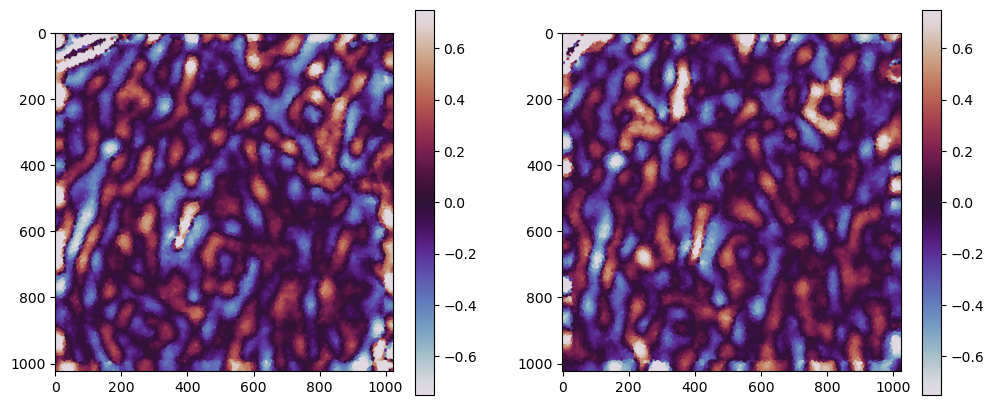

In [67]:
mouse = 'M2'

plt.rcParams['figure.figsize'] = [12, 5]
plt.subplot(1,2,1)
plt.imshow(mean_curve[mouse+'_t0'],vmin=-0.75,vmax=0.75,cmap='twilight')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(mean_curve[mouse+'_t1'],vmin=-0.75,vmax=0.75,cmap='twilight')
plt.colorbar()

plt.gcf().savefig(path.join(dirnames[mouse+'_t0'],'curvature_stability'))

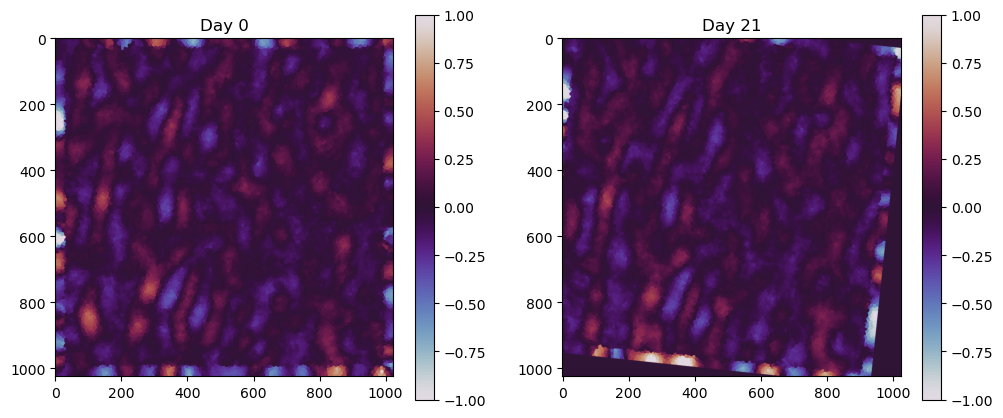

In [90]:
# rotation
from pystackreg import StackReg
from skimage import transform

mouse = 'M2_R2'

Xtrim = slice(100,900)
Ytrim = slice(100,900)

sr = StackReg(StackReg.RIGID_BODY)
T = sr.register(mean_curve[mouse+'_t0'][Xtrim,Ytrim],mean_curve[mouse+'_t1'][Xtrim,Ytrim])
T = transform.EuclideanTransform(T)
# T = T + transform.EuclideanTransform(translation=[0,-5])
# T = T + transform.EuclideanTransform(rotation=np.deg2rad(1))
transformed = transform.warp(mean_curve[mouse+'_t1'],T)
mean_curve[mouse+'_t1_t'] = transformed

plt.subplot(1,2,1)
plt.title('Day 0')
plt.imshow(mean_curve[mouse+'_t0'],clim=[-0.75,0.75],cmap='twilight')
plt.clim([-1,1])
plt.colorbar()

plt.subplot(1,2,2)
plt.title('Day 21')
plt.imshow(transformed,clim=[-0.75,0.75],cmap='twilight')
plt.clim([-1,1])

plt.colorbar()

plt.savefig(path.join(dirnames[mouse+'_t0'],'curvature.svg'))


0.7129438829092299
0.742192229506091
0.8466735563430531
0.6921218205528678
0.5159186555173557
0.6115915113826405


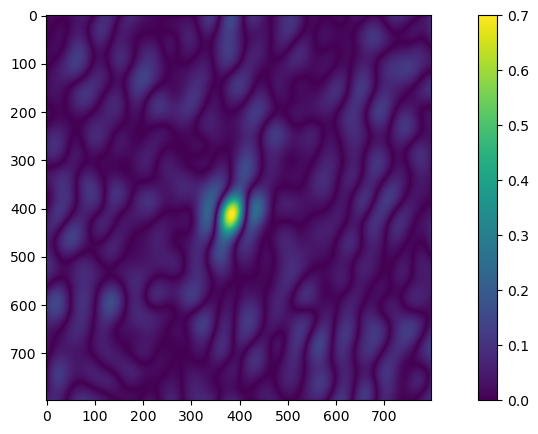

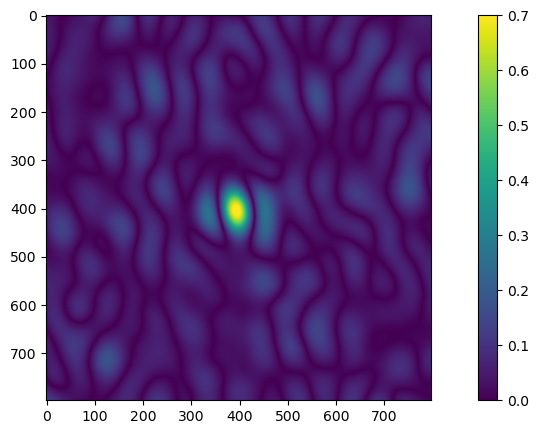

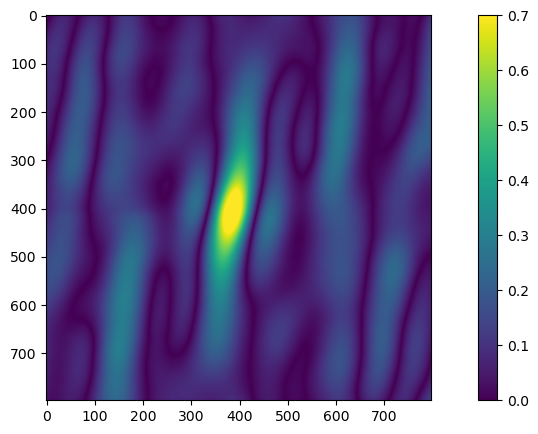

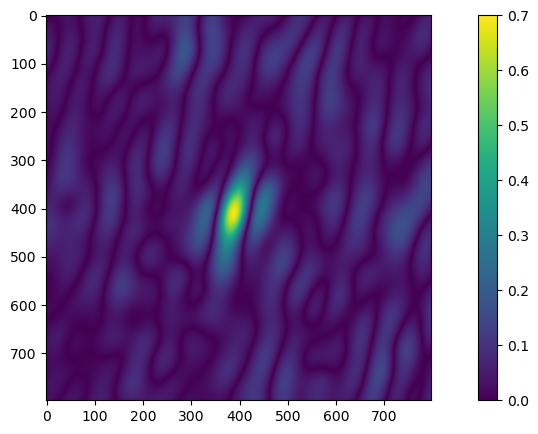

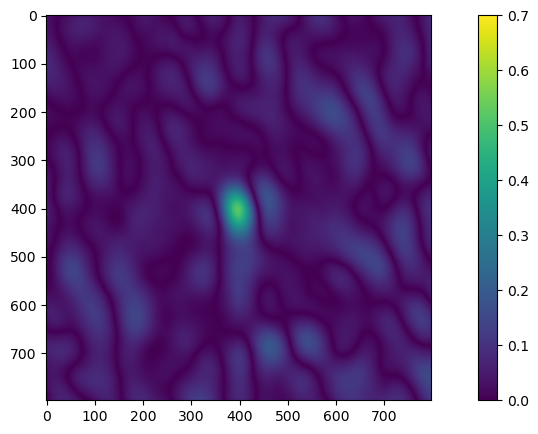

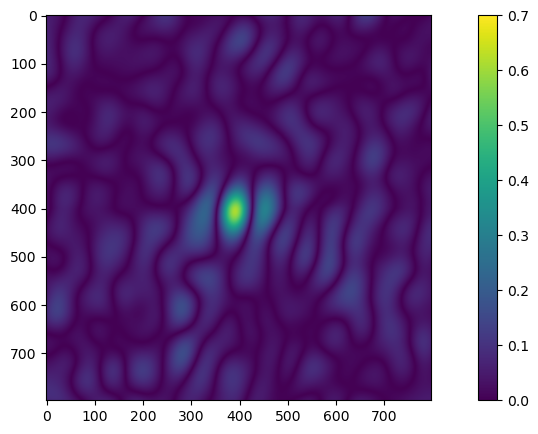

In [102]:
from mathUtils import normxcorr2

spatial_corrs = {}
for mouse in ['M1','M2','M1_R3','M2_R2','M3_R1','M3_R2']:
    
    C = normxcorr2(mean_curve[mouse+'_t0'][Xtrim,Ytrim],
                   mean_curve[mouse+'_t1_t'][Xtrim,Ytrim])
    fig = plt.figure()
    plt.imshow(C[ 1*int(len(C)/4):3*int(len(C)/4), 1*int(len(C)/4):3*int(len(C)/4) ])
    plt.clim([0,.7])
    
    fig.gca().set_aspect('equal', 'box')
    plt.colorbar()
    fig.savefig(path.join(dirname,'spatial_correlation.svg'))
    print(C.max())
    spatial_corrs[mouse] = C

In [109]:
dirname

'/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/10-03-2025 Cdh5-RFP blood vessels/Male 6121/Left paw R2/2. Day 28'

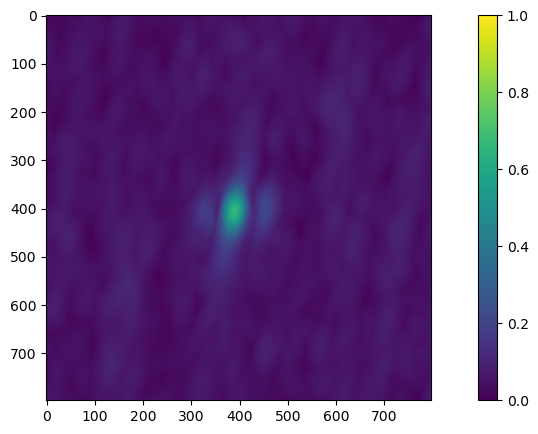

In [116]:
from mathUtils import normxcorr2

meanC = np.mean(np.stack(list(spatial_corrs.values())),axis=0)
plt.imshow(meanC[ 1*int(len(meanC)/4):3*int(len(meanC)/4), 1*int(len(meanC)/4):3*int(len(meanC)/4) ])
plt.clim([0,1])
plt.gca().set_aspect('equal', 'box')
plt.colorbar()
plt.gcf().savefig('/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/mean_spatial_correlation.svg')


Mean: 0.6869069427018729
SEM: 0.042228334197305


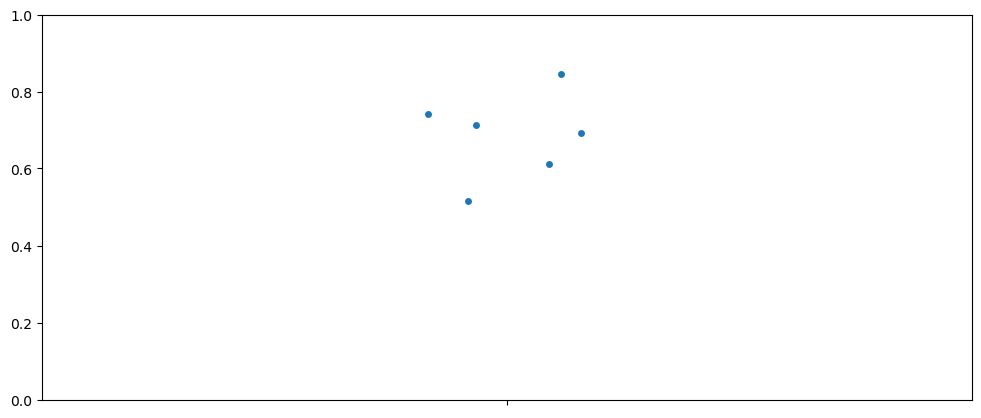

In [98]:
import seaborn as sb

sb.stripplot([C.max() for _,C in spatial_corrs.items()])
# sb.boxplot([C.max() for _,C in spatial_corrs.items()])
plt.ylim([0,1])

print( f'Mean: {np.mean([C.max() for _,C in spatial_corrs.items()])}')
print( f'SEM: {np.std([C.max() for _,C in spatial_corrs.items()])/np.sqrt(len(spatial_corrs))}')

# Save

In [52]:
# Plot alongside the raw images
t0_R = io.imread(path.join(dirname,'0. Day 0/G_reg.tif'))
t1_R = io.imread(path.join(dirname,'1. Day 18/G_reg.tif'))

MIP_t0_R = t0_R.max(axis=0)[Y_trim,X_trim]
MIP_t1_R = t1_R.max(axis=0)[Y_trim,X_trim]

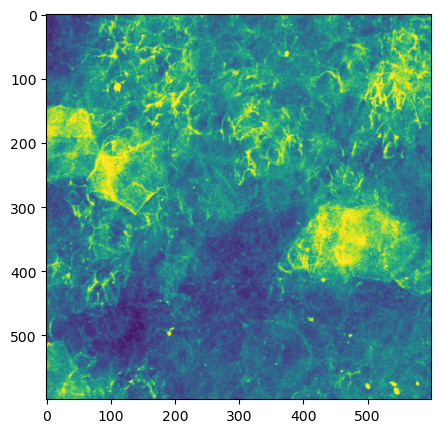

In [53]:
plt.imshow(MIP_t0_R)

In [67]:
t0_curvature

array([-1.67449531, -0.54555334,  0.0944696 , ...,  0.5581811 ,
        0.50719127,  0.5701386 ])

# Use curvature to auto align time points

In [46]:
from trimesh import registration
from scipy.spatial.transform import Rotation

T,_ = registration.mesh_other(t0_mesh,t1_mesh)

pl = pv.Plotter()
pl.add_mesh(t0_mesh,color='red')
pl.add_mesh(t1_mesh)
pl.show()

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x35b834dd0_10&reconnect=auto" class="pyvist…

In [45]:


# transforming mesh1
t1_mesh_transformed = t1_mesh.copy()
t1_mesh_transformed.apply_transform(T)

pl = pv.Plotter()
pl.add_mesh(t0_mesh,color='red')
pl.add_mesh(t1_mesh)
pl.show()

# saving mesh1 as STL file
# mesh1.export('rigidly_aligned_mesh.stl')

Widget(value='<iframe src="http://localhost:51892/index.html?ui=P_0x3a9ea3140_9&reconnect=auto" class="pyvista…

In [47]:
T

array([[ 0.99868526,  0.01642206, -0.0485599 ,  3.4688129 ],
       [-0.01477884,  0.99931233,  0.03400659,  4.04918631],
       [ 0.04908496, -0.03324422,  0.9982412 , 11.27674525],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [33]:
from scipy import ndimage

t1_crop_transformed = ndimage.affine_transform(t1_crop,T)

stackview.slice(t1_crop)

In [5]:
import trimesh
mesh = trimesh.load_mesh('/Users/xies/Downloads/Stanford_Bunny.stl')

pl = pv.Plotter()
pl.add_mesh(pv.wrap(mesh))
pl.show()

Widget(value='<iframe src="http://localhost:56926/index.html?ui=P_0x32179a750_0&reconnect=auto" class="pyvista…

In [6]:
curv = get_tissue_curvatures(mesh)

In [9]:
curv[0].shape

(56203,)